<a href="https://colab.research.google.com/github/pipeton8/6.864-advanced-nlp/blob/main/Assignments/Assignment%202/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2 - Advanced NLP

(c) Felipe del Canto, October 2021
***
***

In [ ]:
# %%bash
# !(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
from IPython.display import clear_output

!rm -rf hw2
!wget https://github.com/pipeton8/6.864-advanced-nlp/raw/main/Assignments/Assignment%202/lab_util.py -P hw2
!wget https://github.com/pipeton8/6.864-advanced-nlp/raw/main/Assignments/Assignment%202/reviews.csv -P hw2

clear_output()

In [ ]:
import sys
sys.path.insert(1,'/content/hw2')

import csv
import itertools as it
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lab_util

from sklearn.pipeline              import Pipeline
from sklearn.decomposition         import TruncatedSVD, PCA
from sklearn.linear_model          import LogisticRegression
from sklearn.ensemble              import RandomForestClassifier
from sklearn.svm                   import LinearSVC
from sklearn.neural_network        import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors             import KNeighborsClassifier

from tqdm.auto import tqdm

# Introduction

In this notebook, you will find code scaffolding for the implementation portion of Homework 2. There are certain parts of the scaffolding marked with `# Your code here!` comments where you can fill in code to perform the specified tasks. After implementing the methods in this notebook, you will need to design and perform experiments to evaluate each method and respond to the questions in the Homework 2 handout (available on Canvas). You should be able to complete this assignment without changing any of the scaffolding code, just writing code to fill in the scaffolding and run experiments.

## Dataset

We're going to be working with a dataset of product reviews. The following cell loads the dataset and splits it into training, validation, and test sets.

In [ ]:
data = []
n_positive = 0
n_disp = 0
np.random.seed(0)

with open("hw2/reviews.csv") as reader:
  csvreader = csv.reader(reader)
  next(csvreader)
  for id, review, label in csvreader:
    label = int(label)

    # hacky class balancing
    if label == 1:
      if n_positive == 2000:
        continue

      n_positive += 1

    if len(data) == 4000:
      break

    data.append((review, label))
    
    if n_disp > 5:
      continue

    n_disp += 1

    print("review:", review)
    print("rating:", label, "(good)" if label == 1 else "(bad)")
    print()

print(f"Read {len(data)} total reviews.")

# Shuffle before splitting
np.random.shuffle(data)
reviews, labels = zip(*data)

# Training (3000 samples)
train_reviews = reviews[:3000]
train_labels = labels[:3000]

# Validation (500 samples)
val_reviews = reviews[3000:3500]
val_labels = labels[3000:3500]

# Testing (500 samples)
test_reviews = reviews[3500:]
test_labels = labels[3500:]

review: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
rating: 1 (good)

review: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
rating: 0 (bad)

review: This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother an

# Part 1: word representations via matrix factorization

First, we'll construct the term-document matrix (look at `/content/hw2/lab_util.py` in the file browser on the left if you want to see how this works).

In [ ]:
vectorizer = lab_util.CountVectorizer()
vectorizer.fit(train_reviews)
td_matrix = vectorizer.transform(train_reviews).T
print(f"TD matrix is {td_matrix.shape[0]} x {td_matrix.shape[1]}")

TD matrix is 2006 x 3000


First, implement the function `learn_reps_lsa` that computes word representations via latent semantic analysis. The `sklearn.decomposition` or `np.linalg` packages may be useful.

In [ ]:
def idf_matrix(matrix, idf_weight = 'idf'):
  """ Given a |V| x n TD matrix, returns the |V| IDF vector associated, where
      idf(w) = log (# documents / (1 + # documents that contain w) )
  """
  reviews_per_word = np.sum(matrix > 0, axis=1, keepdims=True)
  reviews = matrix.shape[1]

  if idf_weight == 'idf':
    return np.log(reviews/(1+reviews_per_word))

def tf_matrix(matrix, tf_weight = 'raw'):
  """
    Given a |V| x n TD matrix, returns the |V| x n tf matrix, weighted according
    to tf_weight.
  """

  if tf_weight == 'raw':
    tf_matrix = matrix

  elif tf_weight == 'term frequency':
    tf_matrix = matrix/matrix.sum()

  elif tf_weight == 'log normalization':
    tf_matrix = np.log(1+matrix)

  elif tf_weight.find('double') != -1:
    try:
      dash_pos = tf_weight.find('-')
      k = float(tf_weight[dash_pos+1:])
      tf_matrix =  k + (1-k) * matrix/matrix.max(axis=0,keepdims=True)
    except:
      print("Double-k misspecified, raw weight applied.")
      tf_matrix = matrix

  return tf_matrix

def learn_reps_lsa(matrix, rep_size, tf_weight='raw', tf_idf=False, idf_weight='idf'):
    # `matrix` is a `|V| x n` matrix (usually a TD matrix), 
    # where `|V|` is the number of words in the vocabulary and `n`
    # is the number of reviews in the (training) corpus.
    # This function should return a `|V| x rep_size` matrix with each
    # row corresponding to a word representation.
    
    LSA_matrix = tf_matrix(matrix, tf_weight)

    if tf_idf:
      # Get IDF vector
      idf = idf_matrix(matrix, idf_weight)

      # Compute TF-IDF matrix
      LSA_matrix = LSA_matrix * idf

    # Initialize svd object
    svd = TruncatedSVD(n_components=rep_size)

    # Decompose TF-IDF matrix
    return svd.fit_transform(LSA_matrix)

Let's look at some representations:

In [ ]:
words = ["good", "bad", "cookie", "jelly", "dog", "the", "3"]
show_tokens = [vectorizer.tokenizer.word_to_token[word] for word in words]

In [ ]:
reps = learn_reps_lsa(td_matrix, 500)
lab_util.show_similar_words(vectorizer.tokenizer, reps, show_tokens)

good 47
  . 1.056
  a 1.101
  but 1.121
  , 1.152
  the 1.157
bad 201
  . 1.396
  taste 1.416
  but 1.434
  a 1.435
  i 1.449
cookie 504
  nana's 0.777
  cookies 1.036
  oreos 1.287
  bars 1.362
  bites 1.425
jelly 351
  twist 1.144
  cardboard 1.230
  advertised 1.382
  peanuts 1.406
  plastic 1.454
dog 925
  food 1.048
  pet 1.069
  pets 1.071
  switched 1.208
  foods 1.230
the 36
  . 0.331
  <unk> 0.366
  of 0.395
  and 0.403
  to 0.422
3 289
  8 1.210
  . 1.239
  the 1.271
  to 1.272
  <unk> 1.279


We've been operating on the raw count matrix, but in class we discussed several reweighting schemes aimed at making LSA representations more informative. 

Here, implement the TF-IDF transform and see how it affects learned representations. While it is okay (and in fact encouraged) to use vectorized numpy operations, you should refrain from using pre-implemented library functions for computing TF-IDF.

How does TF-IDF normalization change the learned similarity function?

In [ ]:
reps_tfidf = learn_reps_lsa(td_matrix, 500, tf_idf=True)
lab_util.show_similar_words(vectorizer.tokenizer, reps_tfidf, show_tokens)

good 47
  . 0.981
  but 1.013
  a 1.030
  and 1.087
  is 1.090
bad 201
  . 1.329
  taste 1.340
  but 1.361
  a 1.372
  not 1.380
cookie 504
  nana's 0.811
  cookies 1.145
  moist 1.437
  bars 1.438
  oreos 1.451
jelly 351
  twist 1.100
  cardboard 1.233
  advertised 1.307
  plastic 1.506
  plum 1.512
dog 925
  food 1.031
  pets 1.097
  pet 1.102
  foods 1.192
  switched 1.250
the 36
  . 0.212
  and 0.269
  <unk> 0.291
  of 0.303
  to 0.323
3 289
  8 1.143
  . 1.173
  to 1.220
  the 1.220
  of 1.234


Now that we have some representations, let's see if we can do something useful with them.

Below, implement a feature function that represents a document as the sum of its
learned word embeddings.

The remaining code trains a logistic regression model on a set of *labeled* reviews; we're interested in seeing how much representations learned from *unlabeled* reviews improve classification.

(Note: the staff solutions for each of the three featurizers achieve accuracies of between .78 and .83 with the full training corpus (3000 examples).)

In [ ]:
def word_featurizer(xs):
    # normalize
    return xs / np.sqrt((xs ** 2).sum(axis=1, keepdims=True))

def lsa_featurizer(xs, reps, idf_weighting = False):
    # This function takes in a `|D| x |V|` TD matrix in which each row contains
    # the word counts for the given review.
    # It should return a matrix where each row contains the learned feature
    # representation of each review (e.g. the sum of LSA word representations).
    # (Hint: use TF-IDF LSA features, which should be a global variable after
    # running the previous cell; no need to pass it in as an argument.)
    feats = np.zeros((xs.shape[0],reps.shape[1]))

    if idf_weighting:
      idf = idf_matrix(xs.T, 'idf')
    else:
      idf = np.ones_like(feats[0,:])

    for i in range(xs.shape[0]):
      doc_wordDummies = (xs[i,:] > 0).T.reshape((-1,1))
      feats[i,:] = np.sum(doc_wordDummies * idf * reps,axis=0, keepdims=True)

    # normalize
    return feats / np.sqrt((feats ** 2).sum(axis=1, keepdims=True))

# We've implemented the remainder of the training and evaluation pipeline,
# so you likely won't need to modify the following four functions.
def combo_featurizer(xs, reps, featurizer2=lsa_featurizer, idf_weighting = False):
    return np.concatenate((word_featurizer(xs), featurizer2(xs, reps, idf_weighting=idf_weighting)), axis=1)

def train_model(xs, ys, featurizer, featurizer_args, featurizer_kwargs, model):
    xs_featurized = featurizer(xs, *featurizer_args, **featurizer_kwargs)

    model.fit(xs_featurized, ys)

    return model

def eval_model(model, xs, ys, featurizer, featurizer_args, featurizer_kwargs):
    xs_featurized = featurizer(xs, *featurizer_args, **featurizer_kwargs)

    pred_ys = model.predict(xs_featurized)

    return np.mean(pred_ys == ys)

def training_experiment(name, n_train, model, featurizer, featurizer_args = [], featurizer_kwargs = {}, verbose=True):
    if verbose:
      print(f"{name} features, {n_train} examples")

    train_xs = vectorizer.transform(train_reviews[:n_train])
    train_ys = train_labels[:n_train]
    test_xs = vectorizer.transform(test_reviews)
    test_ys = test_labels
    model = train_model(train_xs, train_ys, featurizer, featurizer_args, featurizer_kwargs, model)
    acc = eval_model(model, test_xs, test_ys, featurizer, featurizer_args, featurizer_kwargs)

    if verbose:
      print(f"Accuracy is {acc*100:.2f}%")
      print("")

    return acc

In [ ]:
# Train
n_train = 3000
embed_size = 500
model = LogisticRegression()

reps_tfidf = learn_reps_lsa(td_matrix, embed_size, tf_idf=True)
acc = training_experiment("word", n_train, model, word_featurizer)
acc = training_experiment("lsa", n_train, model, lsa_featurizer, 
                          featurizer_args=[reps_tfidf], featurizer_kwargs={'idf_weighting' : True})
acc = training_experiment("combo", n_train, model, combo_featurizer,
                          featurizer_args=[reps_tfidf],featurizer_kwargs={'featurizer2' : lsa_featurizer, 'idf_weighting' : True})

word features, 3000 examples
Accuracy is 78.40%

lsa features, 3000 examples
Accuracy is 80.20%

combo features, 3000 examples
Accuracy is 82.00%



**Part 1: Lab writeup**

Part 1 of your lab report should discuss any implementation details that were important to filling out the code above, as well as your answers to the questions in Part 1 of the Homework 2 handout. Below, you can set up and perform experiments that answer these questions (include figures, plots, and tables in your write-up as you see fit).

## Experiments for Part 1

### Part (a)

In [ ]:
def cosine_similarity(A,B, axis=0):
  """
  Given matrices A and B, computes cosine similarity between column vectors if
  axis = 0 and between rows if axis = 1.
  """
  norm_A = np.linalg.norm(A,axis=axis)
  norm_B = np.linalg.norm(B,axis=axis)
  
  return np.sum(A * B,axis=axis)/(norm_A*norm_B)

Singular values coincide: Yes
Share of vectors with similarity (in absolute value) equal or greater that 0.90: 1.00
Share of vectors with similarity (in absolute value) equal or greater that 0.95: 1.00
Share of vectors with similarity (in absolute value) equal or greater that 0.99: 1.00



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


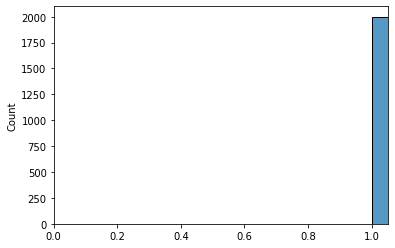

In [ ]:
# Set embed_size and compute W_tt
embed_size = 2000
w_tt = td_matrix @ td_matrix.T

# Initialize SVD objects
svd_TD = TruncatedSVD(n_components=embed_size, random_state=0)
svd_TT = TruncatedSVD(n_components=embed_size, random_state=0)

# Obtain low rand representation
decomposed_TD = svd_TD.fit_transform(td_matrix)
decomposed_TT = svd_TT.fit_transform(w_tt)

# Obtain left_singular vectors (in absolute value)
left_singular_TD = decomposed_TD/svd_TD.singular_values_
left_singular_TT = decomposed_TT/svd_TT.singular_values_

# Singular value similarity
values_TD = svd_TD.singular_values_
values_TT = svd_TT.singular_values_
value_similarity = cosine_similarity(values_TD, np.sqrt(values_TT))

# Compute cosine similarity between each column
vector_similarity = cosine_similarity(left_singular_TD,left_singular_TT)
vector_similarity = np.abs(vector_similarity)

ax = sns.histplot(vector_similarity, binwidth=0.05)
ax.set_xticks([0.2*x for x in range(6)])

print(f"Singular values coincide: " + "Yes"*(value_similarity>=0.99) + "No"*(value_similarity<0.99))
print(f"Share of vectors with similarity (in absolute value) equal or greater that 0.90: {(vector_similarity>=0.90).sum()/embed_size:.2f}")
print(f"Share of vectors with similarity (in absolute value) equal or greater that 0.95: {(vector_similarity>=0.95).sum()/embed_size:.2f}")
print(f"Share of vectors with similarity (in absolute value) equal or greater that 0.99: {(vector_similarity>=0.99).sum()/embed_size:.2f}")
print()

### Part (b)

In [ ]:
words = ['the', 'dog', '3', 'good']
show_tokens = [vectorizer.tokenizer.word_to_token[word] for word in words]

In [ ]:
embed_size = 1000
kwargs = {'tf_weight'  : 'term frequency',
          'tf_idf'     : True}

reps = learn_reps_lsa(td_matrix, embed_size, **kwargs)
lab_util.show_similar_words(vectorizer.tokenizer, reps, show_tokens)

the 36
  . 0.264
  <unk> 0.328
  and 0.342
  of 0.363
  to 0.383
dog 925
  food 1.050
  pets 1.163
  pet 1.182
  foods 1.257
  dogs 1.311
3 289
  . 1.217
  8 1.230
  the 1.262
  to 1.264
  <unk> 1.270
good 47
  . 1.028
  a 1.082
  but 1.105
  and 1.138
  the 1.143


### Part (c)

#### Different training sizes

In [ ]:
# Different training sizes
n_trains = [500*i for i in range(1,7)]
embed_size = 500
model = LogisticRegression()
accs_train_size = {'word'  : [],
                   'lsa'   : [],
                   'combo' : []
                  }

features = ['word', 'lsa', 'combo']

reps = learn_reps_lsa(td_matrix, embed_size, tf_weight='term frequency', tf_idf=True)

for n_train in tqdm(n_trains):
  accs_train_size['word'].append(training_experiment('word', n_train, model, word_featurizer, verbose=False))

  accs_train_size['lsa'].append(
        training_experiment('lsa', n_train, model, lsa_featurizer,
                            featurizer_args=[reps], 
                            featurizer_kwargs={'idf_weighting' : True}, 
                            verbose=False))
  
  accs_train_size['combo'].append(
        training_experiment('combo', n_train, model, combo_featurizer,
                            featurizer_args=[reps], 
                            featurizer_kwargs={'featurizer2' : lsa_featurizer, 
                                                'idf_weighting' : True}, 
                            verbose=False))

  0%|          | 0/6 [00:00<?, ?it/s]

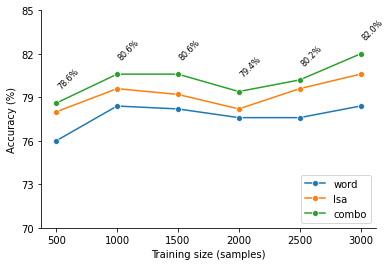

In [ ]:
offset = (0,1)
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for feature in features:
  x = n_trains
  y = [acc*100 for acc in accs_train_size[feature]]
  sns.lineplot(x=x, y=y, label=feature, marker='o', ax=ax)

for i in range(len(n_trains)):
  max_acc = max([accs_train_size[feature][i] for feature in features])*100

  s = f'{max_acc:.1f}%'
  ax.text(x=n_trains[i]+offset[0], 
          y=max_acc+offset[1],
          rotation=45,
          fontsize=8,
          s=s)

plt.yticks([70 + 3*x for x in range(6)])
plt.ylabel("Accuracy (%)")
plt.xticks(n_trains)
plt.xlabel("Training size (samples)")
plt.legend(loc='lower right')

fig.show()

#### Different embedding sizes

In [ ]:
# Different embedding sizes
n_train = 3000
embed_sizes = [100*i for i in range(1,11)]
model = LogisticRegression()
accs_embed_size = {'word'  : [],
                   'lsa'   : [],
                  'combo' : []
                  }

features = ['word', 'lsa', 'combo']

for embed_size in tqdm(embed_sizes):
  reps = learn_reps_lsa(td_matrix, embed_size, tf_weight='term frequency', tf_idf=True)

  accs_embed_size['word'].append(training_experiment('word', n_train, model, word_featurizer, verbose=False))

  accs_embed_size['lsa'].append(
        training_experiment('lsa', n_train, model, lsa_featurizer,
                            featurizer_args=[reps], 
                            featurizer_kwargs={'idf_weighting' : True}, 
                            verbose=False))
  
  accs_embed_size['combo'].append(
        training_experiment('combo', n_train, model, combo_featurizer,
                            featurizer_args=[reps], 
                            featurizer_kwargs={'featurizer2' : lsa_featurizer, 
                                                'idf_weighting' : True}, 
                            verbose=False))

  0%|          | 0/10 [00:00<?, ?it/s]

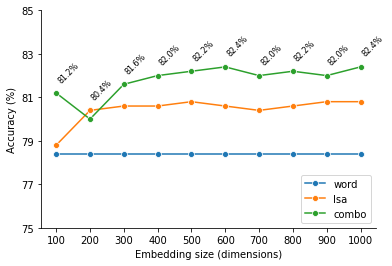

In [ ]:
offset = (0,0.5)
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
features = ['word', 'lsa', 'combo']

for feature in features:
  x = embed_sizes
  y = [acc*100 for acc in accs_embed_size[feature]]
  sns.lineplot(x=x, y=y, label=feature, marker='o', ax=ax)

for i in range(len(embed_sizes)):
  max_acc = max([accs_embed_size[feature][i] for feature in features])*100

  s = f'{max_acc:.1f}%'
  ax.text(x=embed_sizes[i]+offset[0], 
          y=max_acc+offset[1],
          rotation=45,
          fontsize=8,
          s=s)

plt.yticks([75 + 2*x for x in range(6)])
plt.ylabel("Accuracy (%)")
plt.xticks(embed_sizes)
plt.xlabel("Embedding size (dimensions)")
plt.legend(loc='lower right')

fig.show()

### Different classifiers

In [ ]:
# Different classifiers
n_train = 3000
embed_size = 500
models = [LogisticRegression(), RandomForestClassifier(random_state=0), LinearSVC(random_state=0), 
          MLPClassifier(random_state=0), QuadraticDiscriminantAnalysis(), 
          KNeighborsClassifier(n_neighbors=3),KNeighborsClassifier(n_neighbors=5)]
model_names = ['Logit', 'Random Forest', 'SVM', 'MLP', 'QDA', '3-NN', '5-NN']

accs_classifiers = {'word'  : [],
                    'lsa'   : [],
                    'combo' : []
                  }

features = ['word', 'lsa', 'combo']

reps = learn_reps_lsa(td_matrix, embed_size, tf_weight='term frequency', tf_idf=True)

for model in tqdm(models):
  accs_classifiers['word'].append(training_experiment('word', n_train, model, word_featurizer, verbose=False))

  accs_classifiers['lsa'].append(
        training_experiment('lsa', n_train, model, lsa_featurizer,
                            featurizer_args=[reps], 
                            featurizer_kwargs={'idf_weighting' : True}, 
                            verbose=False))
  
  accs_classifiers['combo'].append(
        training_experiment('combo', n_train, model, combo_featurizer,
                            featurizer_args=[reps], 
                            featurizer_kwargs={'featurizer2' : lsa_featurizer, 
                                                'idf_weighting' : True}, 
                            verbose=False))

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


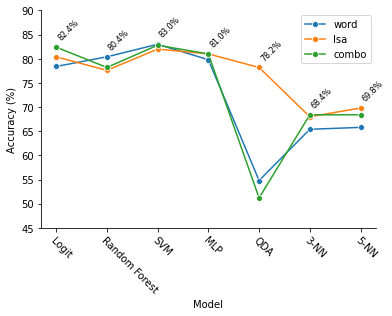

In [ ]:
offset = (0,1.5)
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

features = ['word', 'lsa', 'combo']

for feature in features:
  x = model_names
  y = [acc*100 for acc in accs_classifiers[feature]]
  sns.lineplot(x=x, y=y, label=feature, marker='o', ax=ax)

for i in range(len(model_names)):
  max_acc = max([accs_classifiers[feature][i] for feature in features])*100

  s = f'{max_acc:.1f}%'
  ax.text(x=i+offset[0], 
          y=max_acc+offset[1],
          rotation=45,
          fontsize=8,
          s=s)

plt.yticks([45 + 5*x for x in range(10)])
plt.ylabel("Accuracy (%)")
plt.xticks(np.arange(len(model_names)), model_names, rotation=-45, rotation_mode='anchor', horizontalalignment="left")
plt.xlabel("Model")
plt.legend(loc='upper right')

fig.show()

### Best classifier with different weighting

In [ ]:
# Different embedding sizes
n_train = 3000
embed_size = 500
model = LogisticRegression()
accs_weights = {'word'  : [],
                'lsa'   : [],
                'combo' : []
               }

tf_weights = ['raw', 'term frequency', 'log normalization', 
              'double-0.25', 'double-0.5', 'double-0.75']

features = ['word', 'lsa', 'combo']

for tf_weight in tqdm(tf_weights):
  reps = learn_reps_lsa(td_matrix, embed_size, tf_weight=tf_weight, tf_idf=True)

  accs_weights['word'].append(training_experiment('word', n_train, model, word_featurizer, verbose=False))

  accs_weights['lsa'].append(
        training_experiment('lsa', n_train, model, lsa_featurizer,
                            featurizer_args=[reps], 
                            featurizer_kwargs={'idf_weighting' : True}, 
                            verbose=False))
  
  accs_weights['combo'].append(
        training_experiment('combo', n_train, model, combo_featurizer,
                            featurizer_args=[reps], 
                            featurizer_kwargs={'featurizer2' : lsa_featurizer, 
                                                'idf_weighting' : True}, 
                            verbose=False))

  0%|          | 0/6 [00:00<?, ?it/s]

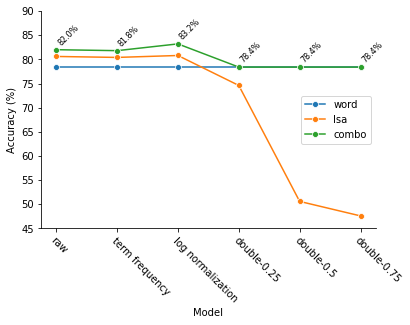

In [ ]:
offset = (0,1)
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
features = ['word', 'lsa', 'combo']

for feature in features:
  x = tf_weights
  y = [acc*100 for acc in accs_weights[feature]]
  sns.lineplot(x=x, y=y, label=feature, marker='o', ax=ax)

for i in range(len(tf_weights)):
  max_acc = max([accs_weights[feature][i] for feature in features])*100

  s = f'{max_acc:.1f}%'
  ax.text(x=i+offset[0], 
          y=max_acc+offset[1],
          rotation=45,
          fontsize=8,
          s=s)

plt.yticks([45 + 5*x for x in range(10)])
plt.ylabel("Accuracy (%)")
plt.xticks(np.arange(len(tf_weights)), tf_weights, rotation=-45, rotation_mode='anchor', horizontalalignment="left")
plt.xlabel("Model")
plt.legend(loc='center right')

fig.show()

# Part 2: word representations via language modeling

In this section, we'll train a word embedding model with a word2vec-style objective rather than a matrix factorization objective. This requires a little more work; we've provided scaffolding for a PyTorch model implementation below.
If you don't have much PyTorch experience, there are some tutorials [here](https://pytorch.org/tutorials/) which may be useful. You're also welcome to implement these experiments in any other framework of your choosing (note that we won't be able to provide debugging support if you use a different framework).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data

class Word2VecModel(nn.Module):
    # A torch module implementing a word2vec predictor. The `forward` function
    # should take a batch of context word ids as input and predict the word 
    # in the middle of the context as output, as in the CBOW model from lecture.
    # Hint: look at how padding is handled in lab_util.get_ngrams when
    # initializing `ctx`: vocab_size is used as the padding token for contexts
    # near the beginning and end of sequences. If you use an embedding module
    # in your Word2Vec implementation, make sure to account for this extra
    # padding token, and account for it with the `padding_idx` kwarg.

    def __init__(self, vocab_size, embed_dim):
        super().__init__()

        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
        self.input_embed = nn.Embedding(vocab_size+1,embed_dim,padding_idx=vocab_size)
        self.output_embed = nn.Embedding(vocab_size+1,embed_dim,padding_idx=vocab_size)

    def forward(self, context):
        # Context is an `n_batch x n_context` matrix of integer word ids
        # this function should return an `n_batch x vocab_size` matrix with
        # element i, j being the (possibly log) probability of the middle word
        # in context i being word j.
        
        # Embed context using output embedding matrix
        embed_context = self.input_embed(context)

        # Project embedded context using average
        proj_context = torch.mean(embed_context, 1)

        # Obtain probability
        prob = torch.matmul(proj_context,self.output_embed.weight.t())[:,:-1]

        # Return log prob
        return F.log_softmax(prob,dim=1)

In [ ]:
def learn_reps_word2vec(corpus, window_size, rep_size, n_epochs, n_batch, device='cuda', embedding_type='input', verbose=True):
    # This method takes in a corpus of training sentences. It returns a matrix
    # of word embeddings with the same structure as used in the previous section 
    # of the assignment. (You can extract this matrix from the parameters of the 
    # Word2VecModel.)

    tokenizer = lab_util.Tokenizer()
    tokenizer.fit(corpus)
    tokenized_corpus = tokenizer.tokenize(corpus)

    ngrams = lab_util.get_ngrams(tokenized_corpus, window_size, pad_idx=tokenizer.vocab_size)

    model = Word2VecModel(tokenizer.vocab_size, rep_size).to(device)
    opt = optim.Adam(model.parameters(), lr=0.001)

    loader = torch_data.DataLoader(ngrams, batch_size=n_batch, shuffle=True)

    # Use the Negative Log Likelihood loss
    loss_fn = nn.NLLLoss(reduction='sum')

    losses = []  # Potentially useful for debugging (loss should go down!)
    for epoch in tqdm(range(n_epochs)):
        epoch_loss = 0
        for context, label in loader:
          context = context.to(device)
          label = label.to(device)

          # As described above, `context` is a batch of context word ids, and
          # `label` is a batch of predicted word labels.

          # Obtain predictions (log-probabilities) using forward of model
          preds = model(context)

          # Now finish the backward pass and gradient update.
          # Remember, you need to compute the loss, zero the gradients
          # of the model parameters, perform the backward pass, and
          # update the model parameters.
          loss = loss_fn(preds,label)
          loss.backward()          
          opt.step()
          opt.zero_grad()

          epoch_loss += loss.item()

        
        if verbose:
          print(f"Loss in epoch {epoch+1}" + " "*(epoch<n_epochs-1) + f": {epoch_loss:.2f}")

        losses.append(epoch_loss)

    # Hint: you want to return a `vocab_size x embedding_size` numpy array
    # Return embedding matrix
    input_embedding_matrix = model.input_embed.weight.data[:-1,:].cpu().numpy()
    output_embedding_matrix = model.output_embed.weight.data[:-1,:].cpu().numpy()

    if embedding_type == 'input':
      return input_embedding_matrix

    elif embedding_type == 'output':
      return output_embedding_matrix 

    elif embedding_type == 'combo':
      return 1/2 * (input_embedding_matrix + output_embedding_matrix)

In [ ]:
torch.manual_seed(0)

# Parameters
window_size = 2
rep_size    = 500
n_epochs    = 20
n_batch     = 100
device      = 'cuda'

# Representations
reps_word2vec = learn_reps_word2vec(train_reviews, window_size, rep_size, n_epochs, n_batch, embedding_type='combo', device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Loss in epoch 1 : 5396952.41
Loss in epoch 2 : 2774056.12
Loss in epoch 3 : 2031070.42
Loss in epoch 4 : 1677616.29
Loss in epoch 5 : 1469701.29
Loss in epoch 6 : 1332792.02
Loss in epoch 7 : 1234739.39
Loss in epoch 8 : 1162346.26
Loss in epoch 9 : 1105968.33
Loss in epoch 10 : 1061448.84
Loss in epoch 11 : 1025744.45
Loss in epoch 12 : 996659.37
Loss in epoch 13 : 972755.66
Loss in epoch 14 : 952759.69
Loss in epoch 15 : 936306.21
Loss in epoch 16 : 922620.30
Loss in epoch 17 : 910782.37
Loss in epoch 18 : 900763.09
Loss in epoch 19 : 892281.07
Loss in epoch 20: 885235.94


After training the embeddings, we can try to visualize the embedding space to see if it makes sense. First, we can take any word in the space and check its closest neighbors.

In [ ]:
words = ["good", "bad", "cookie", "jelly", "dog", "the", "3"]
show_tokens = [vectorizer.tokenizer.word_to_token[word] for word in words]
lab_util.show_similar_words(vectorizer.tokenizer, reps_word2vec, show_tokens)

good 47
  recommended 1.649
  tasting 1.661
  need 1.691
  looked 1.720
  at 1.726
bad 201
  luck 1.617
  wasn't 1.683
  barely 1.697
  certainly 1.720
  for 1.721
cookie 504
  gave 1.660
  shape 1.663
  dough 1.688
  bars 1.691
  nana's 1.703
jelly 351
  regular 1.579
  gummy 1.603
  milder 1.645
  jars 1.698
  mostly 1.708
dog 925
  blend 1.690
  cat 1.694
  healthier 1.700
  stomach 1.714
  again 1.721
the 36
  case 1.657
  . 1.694
  br 1.705
  2 1.715
  which 1.715
3 289
  boxes 1.626
  carton 1.652
  1 1.654
  6 1.666
  20 1.686


We can also cluster the embedding space. Clustering in 4 or more dimensions is hard to visualize, and even clustering in 2 or 3 can be difficult because there are so many words in the vocabulary. One thing we can try to do is assign cluster labels and qualitiatively look for an underlying pattern in the clusters.

In [ ]:
from sklearn.cluster import KMeans

indices = KMeans(n_clusters=10).fit_predict(reps_word2vec)
zipped = list(zip(range(vectorizer.tokenizer.vocab_size), indices))
np.random.shuffle(zipped)
zipped = zipped[:100]
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for token, cluster_idx in zipped:
    word = vectorizer.tokenizer.token_to_word[token]
    print(f"{word}: {cluster_idx}")

dinner: 8
mold: 8
going: 8
wide: 8
english: 8
carried: 8
mixes: 8
sadly: 8
drinker: 8
control: 8
point: 8
economical: 8
previously: 8
began: 8
gifts: 7
onion: 6
choices: 6
extra: 6
sweetness: 6
kernels: 6
intake: 6
balance: 6
bob's: 6
customers: 6
lot: 6
fruit: 6
bonus: 6
sized: 6
oatmeal: 6
peppermint: 6
will: 5
replacement: 5
started: 5
he's: 5
probably: 5
piece: 5
idea: 5
could: 5
24: 5
pieces: 5
mix: 5
fridge: 5
source: 5
half: 5
get: 5
freezer: 5
certified: 5
apart: 5
baby: 4
bits: 4
sounds: 4
dip: 4
trans: 4
free: 4
fit: 4
mccann's: 4
soup: 4
eater: 3
european: 3
none: 3
replace: 3
throwing: 3
olives: 3
child: 3
loss: 3
future: 3
am: 3
teaspoon: 3
soon: 3
post: 3
brought: 3
course: 3
adds: 3
noted: 3
bills: 3
sour: 1
pretty: 1
bake: 1
taste: 1
likes: 1
sugar: 1
absolutely: 1
follow: 1
almost: 1
no: 1
worse: 1
sweet: 1
your: 1
sorry: 0
carries: 0
allowed: 0
our: 0
using: 0
except: 0
included: 0
company: 0
batches: 0
felt: 0
appeal: 0
shipping: 0


Finally, we can use the trained word embeddings to construct vector representations of full reviews. One common approach is to simply average all the word embeddings in the review to create an overall embedding. Implement the transform function in Word2VecFeaturizer to do this.

In [ ]:
def w2v_featurizer(xs, reps, idf_weighting = False):
    # This function takes in a matrix in which each row contains the word counts
    # for the given review. It should return a matrix in which each row contains
    # the average Word2Vec embedding of each review (hint: this will be very
    # similar to `lsa_featurizer` from above, just using Word2Vec embeddings 
    # instead of LSA).

    feats = np.zeros((xs.shape[0],reps.shape[1]))

    if idf_weighting:
      idf = idf_matrix(xs.T, 'idf')
    else:
      idf = np.ones_like(feats[0,:])

    for i in range(xs.shape[0]):
      doc_wordCount = (xs[i,:] > 0).T.reshape((-1,1))
      feats[i,:] = np.sum(doc_wordCount * idf * reps,axis=0, keepdims=True)

    # normalize
    return feats / np.sqrt((feats ** 2).sum(axis=1, keepdims=True))

training_experiment('word2vec', 3000, LogisticRegression(), w2v_featurizer, featurizer_args=[reps_word2vec], verbose=True)
print()

word2vec features, 3000 examples
Accuracy is 80.40%




**Part 2: Lab writeup**

Part 2 of your lab report should discuss any implementation details that were important to filling out the code above, as well as your answers to the questions in Part 2 of the Homework 2 handout. Below, you can set up and perform experiments that answer these questions (include figures, plots, and tables in your write-up as you see fit).

## Experiments for Part 2

### Different context sizes

In [ ]:
torch.manual_seed(0)

# Parameters for W2V
window_sizes = [2*x for x in range(1,11)]
rep_size    = 500
n_epochs    = 20
n_batch     = 100
device      = 'cuda'
embedding_type = 'combo'

# Parameters for classification
n_train = 3000
model = LogisticRegression()

# Initialize accuracy and representation lists
accs_word2vec_window_size = {'word2vec' : [],
                             'word2vec (combo)' : []}
reps_word2vec_window_size = []

for window_size in window_sizes:
  reps_word2vec_window_size.append(learn_reps_word2vec(train_reviews, window_size, rep_size, 
                                      n_epochs, n_batch, embedding_type=embedding_type, 
                                      device=device, verbose=False))

  accs_word2vec_window_size['word2vec'].append(
      training_experiment('word2vec', n_train, model, w2v_featurizer,
                          featurizer_args=[reps_word2vec_window_size[-1]],
                          featurizer_kwargs={'idf_weighting':True}, 
                          verbose=False))

  accs_word2vec_window_size['word2vec (combo)'].append(
      training_experiment('word2vec', n_train, model, combo_featurizer,
                          featurizer_args=[reps_word2vec_window_size[-1]],
                          featurizer_kwargs={'featurizer2'  : w2v_featurizer,
                                             'idf_weighting': True}, 
                          verbose=False))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

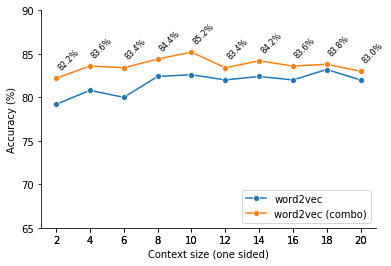

In [ ]:
offset = (0,1)
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

x = window_sizes

for featurizer in list(accs_word2vec_window_size.keys()):
  y = [acc*100 for acc in accs_word2vec_window_size[featurizer]]
  sns.lineplot(x=x, y=y, marker='o', label = featurizer, ax=ax)

for i in range(len(window_sizes)):
  y = max([accs_word2vec_window_size[featurizer][i] for featurizer in list(accs_word2vec_window_size.keys())])*100
  
  s = f'{y:.1f}%'
  ax.text(x=x[i]+offset[0], 
          y=y+offset[1],
          rotation=45,
          fontsize=8,
          s=s)

plt.yticks([65 + 5*x for x in range(6)])
plt.ylabel("Accuracy (%)")
plt.xticks(2*window_sizes)
plt.xlabel("Context size (one sided)")
plt.legend(loc='lower right')

fig.show()

### Different embedding matrices

In [ ]:
torch.manual_seed(0)

# Parameters for W2V
window_size = 12
rep_size    = 500
n_epochs    = 20
n_batch     = 100
device      = 'cuda'

# Parameters for classification
n_train = 3000
embedding_types = ['input', 'output', 'combo']
model = LogisticRegression()

# Initialize accuracy and representation lists
accs_word2vec_embed_type = {'word2vec' : [],
                             'word2vec (combo)' : []}
reps_word2vec_embed_type = []

for embedding_type in embedding_types:
  reps_word2vec_embed_type.append(learn_reps_word2vec(train_reviews, window_size, rep_size, 
                                      n_epochs, n_batch, embedding_type=embedding_type, 
                                      device=device, verbose=False))

  accs_word2vec_embed_type['word2vec'].append(
      training_experiment('word2vec', n_train, model, w2v_featurizer,
                          featurizer_args=[reps_word2vec_window_size[-1]],
                          featurizer_kwargs={'idf_weighting':True}, 
                          verbose=False))

  accs_word2vec_embed_type['word2vec (combo)'].append(
      training_experiment('word2vec', n_train, model, combo_featurizer,
                          featurizer_args=[reps_word2vec_window_size[-1]],
                          featurizer_kwargs={'featurizer2'  : w2v_featurizer,
                                             'idf_weighting': True}, 
                          verbose=False))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

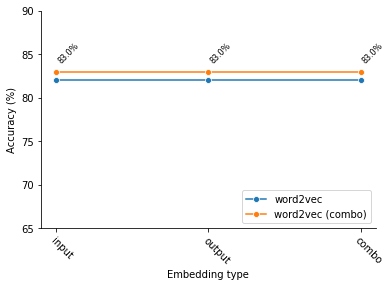

In [ ]:
offset = (0,1)
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

x = embedding_types

for featurizer in list(accs_word2vec_embed_type.keys()):
  y = [acc*100 for acc in accs_word2vec_embed_type[featurizer]]
  sns.lineplot(x=x, y=y, marker='o', label = featurizer, ax=ax)

for i in range(len(embedding_types)):
  y = max([accs_word2vec_embed_type[featurizer][i] for featurizer in list(accs_word2vec_embed_type.keys())])*100
  
  s = f'{y:.1f}%'
  ax.text(x=i+offset[0], 
          y=y+offset[1],
          rotation=45,
          fontsize=8,
          s=s)

plt.yticks([65 + 5*x for x in range(6)])
plt.ylabel("Accuracy (%)")
plt.xticks(np.arange(len(embedding_types)), embedding_types, rotation=-45, rotation_mode='anchor', horizontalalignment="left")
plt.xlabel("Embedding type")
plt.legend(loc='lower right')

fig.show()

### Different classifiers

In [ ]:
torch.manual_seed(0)

# Parameters for W2V
window_size    = 12
rep_size       = 500
n_epochs       = 20
n_batch        = 100
embedding_type = 'input'
device         = 'cuda'


# Different classifiers
n_train = 3000
models = [LogisticRegression(), RandomForestClassifier(random_state=0), LinearSVC(random_state=0), 
          MLPClassifier(random_state=0), QuadraticDiscriminantAnalysis(), 
          KNeighborsClassifier(n_neighbors=3),KNeighborsClassifier(n_neighbors=5)]
model_names = ['Logit', 'Random Forest', 'SVM', 'MLP', 'QDA', '3-NN', '5-NN']

# Initialize accuracy list
accs_word2vec_classifiers = {'word2vec' : [],
                             'word2vec (combo)' : []}

# Representations
reps_word2vec = learn_reps_word2vec(train_reviews, window_size, rep_size, 
                                    n_epochs, n_batch, embedding_type=embedding_type, 
                                    device=device, verbose = False)

for model in tqdm(models):
  accs_word2vec_classifiers['word2vec'].append(
      training_experiment('word2vec', n_train, model, w2v_featurizer,
                          featurizer_args=[reps_word2vec_window_size[-1]],
                          featurizer_kwargs={'idf_weighting':True}, 
                          verbose=False))

  accs_word2vec_classifiers['word2vec (combo)'].append(
      training_experiment('word2vec', n_train, model, combo_featurizer,
                          featurizer_args=[reps_word2vec_window_size[-1]],
                          featurizer_kwargs={'featurizer2'  : w2v_featurizer,
                                             'idf_weighting': True}, 
                          verbose=False))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


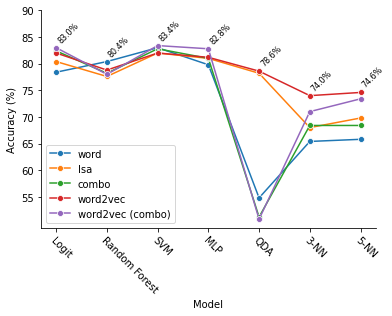

In [ ]:
offset = (0,1)
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
features = ['word', 'lsa', 'combo', 'word2vec', 'word2vec (combo)']

for feature in features:
  x = model_names

  if feature.find('word2vec') != -1:
    y = [acc*100 for acc in accs_word2vec_classifiers[feature]]

  else:
    y = [acc*100 for acc in accs_classifiers[feature]]

  sns.lineplot(x=x, y=y, label=feature, marker='o', ax=ax)

for i in range(len(model_names)):
  max_acc_no_w2v = max([accs_classifiers[feature][i] for feature in features if feature.find('word2vec') == -1])
  max_acc_w2v = max([accs_word2vec_classifiers[feature][i] for feature in features if feature.find('word2vec') != -1])

  max_acc = max([max_acc_no_w2v, max_acc_w2v])*100

  s = f'{max_acc:.1f}%'
  ax.text(x=i+offset[0], 
          y=max_acc+offset[1],
          rotation=45,
          fontsize=8,
          s=s)

plt.yticks([55 + 5*x for x in range(8)])
plt.ylabel("Accuracy (%)")
plt.xticks(np.arange(len(model_names)), model_names, rotation=-45, rotation_mode='anchor', horizontalalignment="left")
plt.xlabel("Model")
plt.legend(loc='lower left')

fig.show()